### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [51]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-3yehrjbx
  Running command git clone --filter=blob:none --quiet https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-3yehrjbx
  Resolved https://github.com/ulaval-damas/glo4030-labs.git to commit 77a2594181ee3c89005c2bc0669ee3007f565568
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Laboratoire 8: Transformers

Dans ce laboratoire, nous allons implémenter l'architecture Transformer de "Attention Is All You Need" (Vaswani, 2017).

In [ ]:
%matplotlib inline

import pathlib
import math

import numpy as np

import torch
import torch.random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

import einops as ein

import deeplib.training as dtrain
import deeplib.datasets as ddatasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Partie 1: Scaled Dot-Product Attention

Au cœur des transformers se trouve le principe d'attention, qui permet de se concentrer sur certaines parties de l'information plutôt que sur d'autres.
Dans le cas des transformers, on utilise le "Scaled Dot-Product Attention" décrit dans "Attention Is All You Need".
Ce principe fonctionne comme une requête sur une hashmap: on fait une requête $q$ (query) selon des clés $k_i$ (keys), et on reçoit la valeur $v_i$ (values) associée à $q$.
Plus formellement, on peut représenter la hashmap comme un ensemble de pair (clé, valeur) $D = \{(k_1, v_1), \ldots (k_n, v_n)\}$, où $k_i$ sont les clés et $v_i$ leur valeur associée.
Ainsi, lorsque l'on fait la requête $q$ sur la base de données $D$, on obtient la valeur associée à $q$.

L'attention est similaire à ce principle, sauf que $q$, $k_i$ et $v_i$ sont tous des vecteurs, et la réponse est une somme pondérée de $v_i$.
Ainsi, l'attention calcule la fonction suivante:
$$Transformer(q, D) = \sum_{i=1}^{n}{\alpha(q, k_i)v_i}$$

L'attention portée à une valeur est donnée par $\alpha(q, k_i)$.
Il s'agit en quelque sorte d'une mesure de la similarité entre la requête $q$ et les clés $k_i$.
Comme le nom "Scaled Dot-Product Attention" laisse deviner, cette similarité, $\alpha(\cdot)$, est un produit scalaire entre les vecteurs $q$ et $k_i$:

$$\alpha(q, k_i) = \frac{qk_i^T}{\sqrt{d}} = \frac{q \cdot k_i }{\sqrt{d}}$$

$d$ est le nombre de dimension des vecteurs. On justifiera le facteur d'échelle de $\frac{1}{\sqrt{d}}$ plus tard dans le laboratoire.


On normalise souvent cette valeur à l'aide d'une softmax afin de garder chaque pondération positive et sommant à 1.

$$\alpha(q, k_i) = \frac{\exp(\alpha(q, k_i))}{\sum_j\exp(\alpha(q, k_j))}$$

Ainsi, le calcul d'attention dans un Transformer est:

$$\alpha(q, k_i) = \frac{\exp\left(q \cdot k_i / \sqrt{d}\right)}{\sum_j\exp\left(q \cdot k_j / \sqrt{d}\right)}$$

Ensuite, il est possible de prendre une somme pondérée des valeurs $v_i$ selon $\alpha(q, k_i)$:

$$Transformer(q, D) = \sum_{i=1}^{n}{\alpha(q, k_i)v_i}$$

Dans la cellule suivante, remplisser la fonction suivante pour appliquer l'attention sur les tenseurs $q$, $k$ et $v$.
Les dimensions des tenseurs sont spécifiés en commentaire.
Utilisez `F.softmax` pour normaliser l'attention.

Assurez-vous que votre calcul d'attention donne bien la valeur attendue.

In [53]:
def simple_attention(q, k, v):
    """
    Attention simple
    q est un tenseur de dimension (1, d)
    k est un tenseur de dimension (n, d)
    v est un tenseur de dimension (n, d)
    d est la dimension des vecteurs, n le nombre de clés et de valeurs
    La sortie devrait être de dimension (1, d)
    """
    # TODO
    d = q.size(-1)
    alpha = F.softmax(q @ k.T / np.sqrt(d), dim=1)
    return alpha @ v
    
q = F.normalize(torch.tensor([[3.0, 3.0]]), dim=1)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [-2, -1], [0, 2]]), dim=1)

expected = torch.tensor([[-0.3584,  0.4563]])
output = simple_attention(q, k, v)

print(f'simple_attention(q, k, v) =\t{output}')
print(f'valeur attendue =\t\t\t{expected}')

simple_attention(q, k, v) =	tensor([[-0.3584,  0.4563]])
valeur attendue =			tensor([[-0.3584,  0.4563]])


### Visualisation de l'attention
Le produit scalaire peut aussi s'écrire sous la forme $q\cdot k_i = \|q\|\|k_i\|\cos(\theta)$, où $\theta$ est l'angle entre les vecteurs.
Si on fait l'hypothèse que les vecteurs en jeux sont unitaires, alors on a que le produit scalaire entre deux donne une mesure d'à quel point les vecteurs sont alignés.
On utilise cette interprétation du produit scalaire pour mieux visualiser ce que fait le Scaled Dot-Product Attention.

Dans la cellule suivante, remplissez le `TODO` avec le calcul pour calculer `alpha`, le vecteur d'attention.

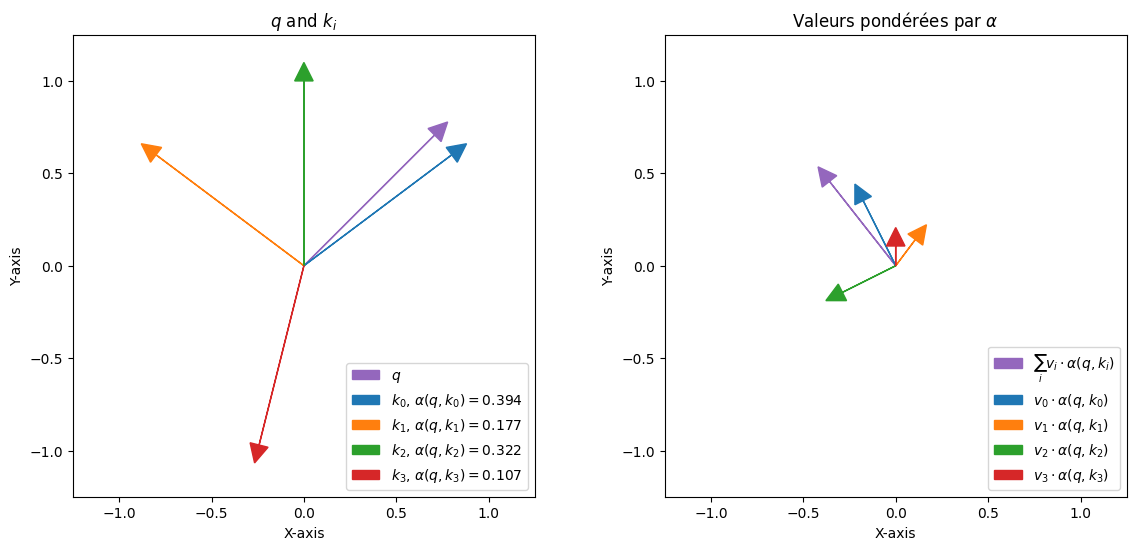

In [54]:
def show_attention(q, k, v):
    # TODO
    d = q.size(-1)
    alpha = F.softmax(q @ k.T / np.sqrt(d), dim=1)
    
    figs, axes = plt.subplots(ncols=2, figsize=(14, 6))
    ax = axes[0]
    ax.arrow(0, 0, q[0][0], q[0][1], head_width=0.1, head_length=0.1, fc='C4', ec='C4', label='$q$')

    colors = ['C0', 'C1', 'C2', 'C3']
    for i, k_i in enumerate(k):
        ax.arrow(0, 0, k_i[0], k_i[1], head_width=0.1, head_length=0.1, label=f'$k_{i}$, $\\alpha(q, k_{i}) = {alpha[0][i]:.3f}$', fc=colors[i], ec=colors[i])

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('$q$ and $k_i$')
    ax.legend(loc='lower right')
    ax.set_aspect('equal', adjustable='box')
    
    ax = axes[1]
    ax.arrow(0, 0, output[0][0], output[0][1], head_width=0.1, head_length=0.1, fc='C4', ec='C4', label='$\sum_i v_{i} \cdot \\alpha(q, k_{i})$')

    for i, v_i in enumerate(v):
        v_i = v_i * alpha[0, i]
        ax.arrow(0, 0, v_i[0], v_i[1], head_width=0.1, head_length=0.1, label=f'$v_{i} \cdot \\alpha(q, k_{i})$', fc=colors[i], ec=colors[i])

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(r'Valeurs pondérées par $\alpha$')
    ax.legend(loc='lower right')
    ax.set_aspect('equal', adjustable='box')

    plt.show()
    
show_attention(q, k, v)

#### Questions
- Visuellement, quel clé est la plus alignée avec $q$? Que peut-on dire de la valeur de $\alpha$ correspondante? Qu'est-ce que cela veut-dire à propose de la valeur finale?

La clé la plus alignée est $k_0$.
Son score d'attention de $0.394$ est plus élevé que les autres.
Le vecteur résultant sera plus près de $v_0$, car il a une plus grande pondération.

- Que ce passe-t'il si vous changez tous les $k_i$ afin qu'ils soient opposés à $q$, sauf un? Quel est l'impact sur la valeur retournée par l'attention?

Le vecteur résultant sera la valeur correspondant à la clé alignée avec la requête.

- Que ce passe-t'il si vous changez tous les $k_i$ afin qu'ils soient opposés à $q$, sauf **deux** qui ont des valeurs égales? Quel est l'impact sur la valeur retournée par l'attention?

Le vecteur résultant sera la moyenne des deux valeurs correspondantes.

### Plusieurs requêtes

Maintenant, on veut implémenter l'attention avec plusieurs requêtes $q_i$.
On veut comparer chaque $q_i$ avec chaque $k_i$.
Afin d'accélérer le calcul de l'attention, on va représenter cette opération grâce à une multiplication de tenseurs.

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)V$$

$$Q=\begin{pmatrix}
q_1\\
q_2\\
\vdots\\
q_n
\end{pmatrix}_{n\times d}, K=\begin{pmatrix}
k_1\\
k_2\\
\vdots\\
k_n
\end{pmatrix}_{n\times d}, V=\begin{pmatrix}
v_1\\
v_2\\
\vdots\\
v_n
\end{pmatrix}_{n\times d}$$

Chaque $q_i$, $k_i$ et $v_i$ sont des vecteurs de dimensions $d$.

La comparaison de chaque $q_i$ et $k_i$ se fait lors du produit suivant:

$$QK^T = \begin{pmatrix}
q_1\\
q_2\\
\vdots\\
q_n
\end{pmatrix}_{n\times d} \begin{pmatrix}
k_1 & k_2 & \dots & k_n
\end{pmatrix}_{d\times n} = \begin{pmatrix}
q_1k_1 & q_1k_2 & \dots  & q_1k_n \\
q_2k_1 & q_2k_2 & \dots  & q_2k_n \\
\vdots & \vdots & \ddots & \vdots \\
q_nk_1 & q_nk_2 & \dots  & q_nk_n \\
\end{pmatrix}_{n\times n}$$

On appelle $QK^T$ la matrice d'attention.
Chaque élément de cette matrice correspond au produit scalaire entre une requête et une clé.

Si on ignore la softmax et le facteur d'échelle, on obtient bel et bien une somme pondérée des valeurs, selon la similarité entre les clés et les requêtes.

$$QK^TV = \begin{pmatrix}
q_1k_1 & q_1k_2 & \dots  & q_1k_n \\
q_2k_1 & q_2k_2 & \dots  & q_2k_n \\
\vdots & \vdots & \ddots & \vdots \\
q_nk_1 & q_nk_2 & \dots  & q_nk_n \\
\end{pmatrix}_{n\times n}\begin{pmatrix}
v_1\\
v_2\\
\vdots\\
v_n
\end{pmatrix}_{n\times d}=\begin{pmatrix}
q_1k_1v_1 + q_1k_2v_2 + \dots  + q_1k_nv_n \\
q_2k_1v_1 + q_2k_2v_2 + \dots  + q_2k_nv_n \\
\vdots \\
q_nk_1v_1 + q_nk_2v_2 + \dots  + q_nk_nv_n \\
\end{pmatrix}_{n\times d}$$

Notez que l'application de la softmax se fera sur la dernière dimension de la matrice d'attention.

Dans la cellule suivante, implémenter l'attention en batch avec plusieurs requêtes.
Les dimensions des tenseurs sont spécifiés en commentaire.

Assurez-vous que votre calcul d'attention donne bien la valeur attendue.

In [55]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Attention sur batch
    q est un tenseur de dimension (b, n, d)
    k est un tenseur de dimension (b, n, d)
    v est un tenseur de dimension (b, n, d)
    b est la taille de la mini-batch, n le nombre de clés et de valeurs, d est la dimension des vecteurs
    La sortie devrait être de dimension (b, n, d)
    """
    # TODO
    attention = q.bmm(k.transpose(-2, -1))  # or query @ key.transpose(1, 2)
    if mask is not None:
        attention[:, mask.logical_not()] = -torch.inf
    
    scale = q.size(-1) ** 0.5
    softmax = F.softmax(attention / scale, dim=-1)
    return softmax.bmm(v)

q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)

expected = torch.tensor([[[0.1089, 0.3322], [0.2860, 0.2639], [0.0600, 0.6791], [0.0986, 0.7087]]])
output = scaled_dot_product_attention(q, k, v)

print(f'scaled_dot_product_attention(q, k, v) =\n{output}')
print(f'valeur attendue =\n{expected}')

scaled_dot_product_attention(q, k, v) =
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])
valeur attendue =
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])


#### Questions
- Quelle est la taille du tenseur lorsque l'on multiple $q$ et $k$? Est-ce problématique pour le temps de calculs et la mémoire utilisée si $n$ (le nombre de queries, keys et valeurs) augmente?

Lorsque l'on compare $n$ éléments à $n$ autres, il y à $n^2$ comparaisons possibles.
Ainsi, la matrice d'attention résultante des dimensions $n\times n$, soit en $O(n^2)$.
Ceci est un enjeu important puisque la taille de la matrice (espace mémoire nécessaire, et temps de calcul) augmente selon le carré du nombre de requêtes et de clés.
Ceci limite la valeur de $n$ qu'il est possible d'utiliser en pratique.


#### Masques
Implémentez l'opération de masque dans la fonction `scaled_dot_product_attention`.
Le masque permet d'empêcher certaines requêtes de porter attention à certaines valeurs.

Ceci est possible en remplaçant les éléments de la matrice d'attention par $-\infty$ où `mask` est `False`

In [56]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)
mask = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]], dtype=torch.bool)

expected = torch.tensor([[[-0.4472,  0.8944], [ 0.1639,  0.8393], [ 0.1129,  0.3967], [ 0.0986,  0.7087]]])
output = scaled_dot_product_attention(q, k, v, mask)

print(f'scaled_dot_product_attention(q, k, v) =\n{output}')
print(f'valeur attendue =\n{expected}')

scaled_dot_product_attention(q, k, v) =
tensor([[[-0.4472,  0.8944],
         [ 0.1639,  0.8393],
         [ 0.1129,  0.3967],
         [ 0.0986,  0.7087]]])
valeur attendue =
tensor([[[-0.4472,  0.8944],
         [ 0.1639,  0.8393],
         [ 0.1129,  0.3967],
         [ 0.0986,  0.7087]]])


#### Visualisation de l'attention
Il est aussi possible de visualiser directement la matrice d'attention.

Dans la cellule suivate, calculez l'attention avec un masque.

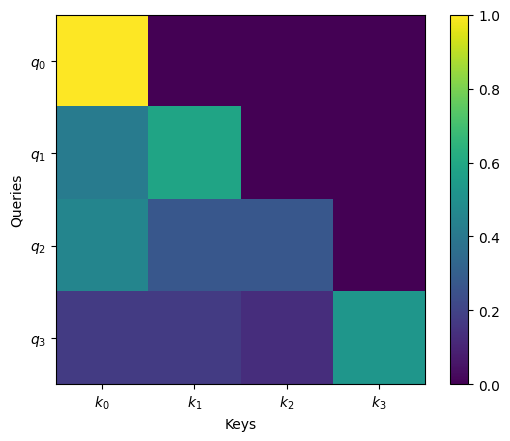

In [57]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)
mask = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]], dtype=torch.bool)
# mask = torch.ones((4, 4), dtype=torch.bool)

# TODO
attention = q.bmm(k.transpose(-2, -1)) / q.size(-1) ** 0.5
attention[:, mask.logical_not()] = -torch.inf
softmax = F.softmax(attention, dim=-1)
output = softmax.bmm(v)

qs = [f'$q_{i}$' for i in range(q.size(1))]
ks = [f'$k_{i}$' for i in range(q.size(1))]

plt.imshow((softmax[0]))

plt.xticks(range(q.size(1)), ks)
plt.yticks(range(q.size(1)), qs)

plt.xlabel('Keys')
plt.ylabel('Queries')

plt.colorbar()
plt.show()

#### Questions
- Que se passe-t'il lors de l'ajout d'un masque?

Les pixels correspondants sont mis à zéro.
Une $q_i$ ne peut donc pas tenir compte que la valeur correspondant à la clé $k_j$.

- Pour les questions suivantes, n'utilisez pas de masque.

- Que se passe-t'il si on change l'ordre des requêtes $q$? Vous pouvez changer l'ordre manuellement avec `q = q[:, [1, 0, 2, 3]]`.

L'ordre des vecteurs en sortie sera aussi permuté, mais conserveront les mêmes valeurs.

```
# sans permutation
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])
# avec permutation
tensor([[[0.2860, 0.2639],
         [0.1089, 0.3322],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])
```

Ainsi, les Transformers sont invariants à l'ordre de $q$.

- Que se passe-t'il si on change l'ordre des clés et des valeurs? Vous devez permuter $k$ et $v$ de la même façon.

La sortie sera exactement la même.
La permutation de l'ordre des paires $(k_i, v_i)$, ne change pas la pondération de chaque vecteur.
Ainsi, les Transformer sont aussi invariants à l'ordre des $(k_i, v_i)$.


- Est-ce l'invariance à l'ordre des entrées est problématique? Quant est-t'il si l'ordre est important? par exemple en traitement de la langue naturelle.

C'est problématique puisque le Transformer n'est simplement pas capable d'extraire de l'information sur l'ordre de $q$, $(k_i, v_i)$.
Dans le cas du traitement de la langue naturelle, le Transformer ne serait pas capable de distinguer l'ordre de la phrase.
Ainsi, les phrases "Alice aime Bob" et "Bob aime Alice" seraient les mêmes pour un Transformer, même si leur sens n'est pas le même.
Il faut ajouter un encodage de position pour donner de l'information sur la position.


### Encodage de position
Comme on vient de le remarquer, les Transformers sont invariants à la permutation des $q_i$ et des paires $(k_i, v_i)$, on doit donc encoder l'information sur la position directement dans ces vecteurs.
Pour ce faire, on utilise une suite de sinus et de cosinus.

L'idée est de générer des vecteurs où chaque composante oscille à des fréquences différentes.
Comme illustré dans la figure suivante issue de [Visual Guide to Transformer Neural Networks, Hedu AI](https://www.youtube.com/watch?v=dichIcUZfOw), chaque vecteur (une slice verticale dans le graphique) permet de représenter une position dans la séquence.
Les composantes avec une fréquence faible (en bleu) permettent d'avoir un estimé de la position sur l'ensemble de la séquence, mais avec peu de précision.
Les composantes avec une fréquence élevée (en rouge) permettent d'avoir une estimation plus précise de la position, mais seulement sur une petite partie de la séquence puisque les valeurs se répètent périodiquement.

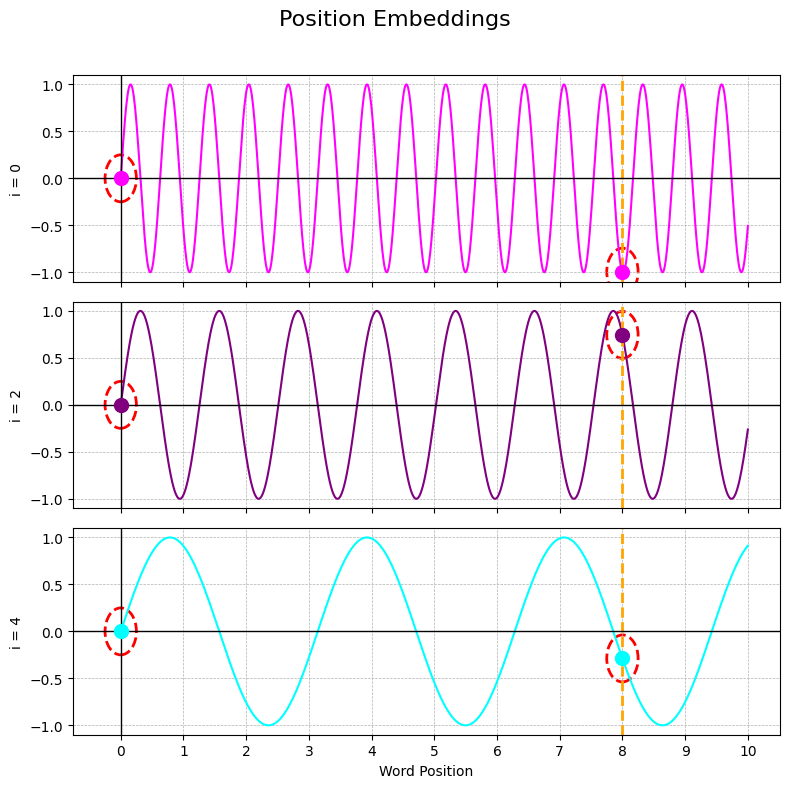

In [58]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# Define the x values (word positions) and different frequencies
x = np.linspace(0, 10, 1000)
y1 = np.sin(10 * x)  # High frequency for i = 0
y2 = np.sin(5 * x)   # Medium frequency for i = 2
y3 = np.sin(2 * x)   # Low frequency for i = 4

# Plot the sine waves on individual axes
axs[0].plot(x, y1, color='magenta', label='i = 0')
axs[1].plot(x, y2, color='purple', label='i = 2')
axs[2].plot(x, y3, color='cyan', label='i = 4')

# Highlight specific word positions (x = 0, x = 7.5)
highlight_x = [0, 8]
highlight_y1 = [np.sin(10 * pos) for pos in highlight_x]
highlight_y2 = [np.sin(5 * pos) for pos in highlight_x]
highlight_y3 = [np.sin(2 * pos) for pos in highlight_x]

# Highlight points on the curves for each axis
axs[0].scatter(highlight_x, highlight_y1, color='magenta', s=100, zorder=5)
axs[1].scatter(highlight_x, highlight_y2, color='purple', s=100, zorder=5)
axs[2].scatter(highlight_x, highlight_y3, color='cyan', s=100, zorder=5)

# Add dashed circles around points for each plot
for x_val, y_val in zip(highlight_x, highlight_y1):
    axs[0].add_patch(plt.Circle((x_val, y_val), 0.25, color='red', fill=False, linestyle='--', linewidth=2))

for x_val, y_val in zip(highlight_x, highlight_y2):
    axs[1].add_patch(plt.Circle((x_val, y_val), 0.25, color='red', fill=False, linestyle='--', linewidth=2))

for x_val, y_val in zip(highlight_x, highlight_y3):
    axs[2].add_patch(plt.Circle((x_val, y_val), 0.25, color='red', fill=False, linestyle='--', linewidth=2))

# Add vertical lines at the highlight positions across all subplots
for ax in axs:
    for h_x in highlight_x[1:]:
        ax.axvline(h_x, color='orange', linestyle='--', linewidth=2)

# Set labels for each subplot
axs[0].set_ylabel('i = 0')
axs[1].set_ylabel('i = 2')
axs[2].set_ylabel('i = 4')
axs[2].set_xlabel('Word Position')

# Set grid and titles
for ax in axs:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.axhline(0, color='black',linewidth=1)
    ax.axvline(0, color='black',linewidth=1)

# Add a shared title for all subplots
fig.suptitle('Position Embeddings', fontsize=16)

# Show all word positions
for ax in axs:
    ax.set_xticks(np.arange(0, 11, 1))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


Dans la cellule suivante, implémenter un encodage de position similaire à ce qui est utilisé dans "Attention Is All You Need".
Il faudra générer un tenseur de dimensions $(1, n, d)$, où $n$ est le nombre d'éléments et $d$ le nombre de dimension de $q_i$.
Générez l'encodage selon cet encodage:

$$\text{PE}_{pos, 2i} = \sin(\text{pos} / 10000^{i/d})$$

$$\text{PE}_{pos, 2i + 1} = \cos(\text{pos} / 10000^{i/d})$$

Où $\text{pos}$ est la position dans la séquence (de 0 à $n - 1$) et $i$ est l'index dans le vecteur (de 0 à $d - 1$).


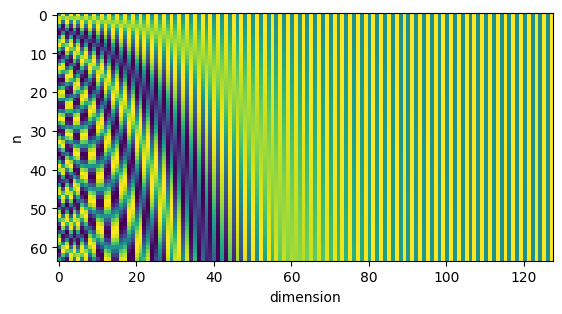

In [59]:
def position_encoding(n_keys: int, dimension: int, device: torch.device = torch.device("cpu")):
    # TODO
    pos = torch.arange(n_keys, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dimension, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (10000 ** (dim / dimension))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

pe = position_encoding(64, 128)
plt.imshow(pe.squeeze())
plt.xlabel('dimension')
plt.ylabel('n')
plt.show()

Dans la cellule suivante, ajoutez de l'encodage de position sur $q$ et $k$.

In [60]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)

_, n, d = q.shape

# TODO
q += position_encoding(n, d)
k += position_encoding(n, d)

scaled_dot_product_attention(q, k, v)

tensor([[[0.2614, 0.0326],
         [0.2765, 0.0179],
         [0.1590, 0.2344],
         [0.1739, 0.4437]]])

#### Questions
- Maintenant, que se passe-t'il lorsque l'on permute les $q_i$? et les $(k_i, v_i)$ après l'ajout de l'encodage de position?

Comme la position est encodé dans les vecteurs, la permutation des vecteurs change la sortie de l'attention.

### Le "Scaled" dans Scaled Dot-Product Attention

Le facteur de $\frac{1}{\sqrt{d}}$ peut sembler inutile, pourtant, il est crucial à l'optimisation des Transformers.
Si on fait l'hypothèse que $q_i$ et $k_i$ suivent une distribution normale $\mathcal{N}(0, 1)$, le produit entre $q$ et $k$ aura une variance de $d$.
Il faut donc diviser par $\sqrt{d}$ afin d'obtenir une variance de $1$.

Dans la cellule suivante, calculez `attention` en faisant le produit entre $q$ et $k$ sans le facteur d'échelle.
Ensuite, calculez `scaled_attention` en y ajoutant le facteur de $\frac{1}{\sqrt{d}}$.

Comparez la variance dans les deux cas.

In [61]:
torch.manual_seed(1337)
num_tokens = 32
dimension = 256

q = torch.randn(num_tokens, dimension)
k = torch.randn(num_tokens, dimension)

# TODO
attention = q @ k.T
# TODO
scaled_attention = attention * dimension ** -0.5

# TODO
print(f'Variance sans scaling: {attention.var()}')
print(f'Variance avec scaling: {scaled_attention.var()}')

Variance sans scaling: 259.6633605957031
Variance avec scaling: 1.0143100023269653


#### Questions
- Justifiez pourquoi la variance est de $d$

Lors du produit scalaire, on fait la somme de $d$ éléments qui ont tous une variance unitaire.
Ainsi, la variance est de $\sum_{i=1}^{d}1=d$.


#### Impact sur les Transformers

Quel est l'impact d'une grande variance sur la softmax?

Comparez la sortie de la softmax des vecteurs `attention` et `scaled_attention` de la cellule précédente.

In [62]:
low_variance = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)
high_variance = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * np.sqrt(256), dim=-1)

# TODO
print(f'Softmax avec faible variance:\n\t{[round(x.item(), 5) for x in low_variance]}')
print(f'Softmax avec haute variance:\n\t{[round(x.item(), 5) for x in high_variance]}')

Softmax avec faible variance:
	[0.1925, 0.14261, 0.23512, 0.14261, 0.28717]
Softmax avec haute variance:
	[0.00159, 1e-05, 0.0391, 1e-05, 0.95928]


#### Questions
- Que remarquez-vous du vecteur softmax lorsque la variance est grande?

Lorsque la variance est grande, le vecteur converge vers un vecteur one-hot.

- Pourquoi est-ce que ceci serait mauvais le Transformer?

Si le vecteur softmax est one-hot, cela veut dire qu'une seule valeur contribut au calcul, ce qui limite les performances du réseau en forçant une convergence vers une seule valeur trop tôt dans l'entraînement.
Au final, on n'aggrège de l'information que d'une seule valeur plutôt que de l'ensemble des éléments.

## Partie 2: Multi-Head Attention
On va maintenant créer un module PyTorch utilisant l'attention.

### AttentionHead
On commence par définir `AttentionHead`, un module représentant une tête d'attention à l'intérieur d'un Transformer.
- On projette `q`, `k`, et `v` avec des couches linéaires sans biais.
- On applique du dropout sur la matrice d'attention après la softmax.

Remplissez les TODOs dans le code suivant.

In [63]:
class AttentionHead(nn.Module):
    def __init__(self, dim_embed: int, head_size: int, dropout: float):
        super().__init__()
        # TODO trois couches linéaires sans biais
        self.q_proj = nn.Linear(dim_embed, head_size, bias=False)
        self.k_proj = nn.Linear(dim_embed, head_size, bias=False)
        self.v_proj = nn.Linear(dim_embed, head_size, bias=False)
        
        # TODO dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        B, T, C = q.shape
        # TODO
        q, k, v = self.q_proj(q), self.k_proj(k), self.v_proj(v)
        
        # TODO
        attention = q.bmm(k.transpose(-2, -1))  # or query @ key.transpose(1, 2)
        
        # TODO
        if mask is not None:
            attention[:, mask[:T, :T].logical_not()] = -torch.inf
    
        # TODO
        scale = q.size(-1) ** 0.5
        softmax = F.softmax(attention / scale, dim=-1)
        
        # TODO
        softmax = self.dropout(softmax)
        
        return softmax.bmm(v)

    
head = AttentionHead(16, 32, 0.1)
x = torch.randn((1, 6, 16))
output = head(x, x, x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(1, 6, 32)}')

Shape 		= (1, 6, 32)
Expected shape 	= (1, 6, 32)


### Multi-Head Attention
On définit maintenant le module `MultiHeadAttention` qui utilise plusieurs têtes d'attention séparées.
- Plusieurs têtes d'attention.
- Concaténation des sorties de chaque tête
- Couche linéaire
- Dropout

Remplissez les TODOs dans le code suivant.

In [64]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_embed: int, head_size: int, dropout: float):
        super().__init__()
        # TODO
        self.heads = nn.ModuleList([AttentionHead(dim_embed, head_size, dropout) for _ in range(num_heads)])
        # TODO
        self.fc = nn.Linear(num_heads * head_size, dim_embed)
        # TODO
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        # TODO
        out = torch.cat([h(q, k, v, mask) for h in self.heads], dim=-1)
        # TODO
        return self.dropout(self.fc(out))

    
m_head = MultiHeadAttention(3, 32, 256, 0.1)
x = torch.randn((1, 6, 32))
output = m_head(x, x, x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(1, 6, 32)}')

Shape 		= (1, 6, 32)
Expected shape 	= (1, 6, 32)


## Partie 3: TransformerEncoderLayer

### FeedForward
On définit maintenant le réseau `FeedForward` utilisé dans le Transformer.

- Linear: dim_model -> 4 * dim_model
- ReLU
- Linear: 4 * dim_model -> dim_model
- Dropout

In [65]:
class FeedForward(nn.Module):
    def __init__(self, dim_model: int, dropout: float):
        super().__init__()
        # TODO
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, 4 * dim_model),
            nn.ReLU(),
            nn.Linear(4 * dim_model, dim_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.ffn(x)


### TransformerEncoderLayer
On peut maintenant construire une couche du Transformer.

- LayerNorm
- MultiHeadAttention
- Connexion résiduelle
- LayerNorm
- FeedForward
- Connexion résiduelle

In [66]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim_model: int, num_head: int, dropout: float):
        super().__init__()
        # TODO
        head_size = dim_model // num_head
        self.attention = MultiHeadAttention(num_head, dim_model, head_size, dropout)
        self.ffn = FeedForward(dim_model, dropout)
        self.norm1_q = nn.LayerNorm(dim_model)
        self.norm1_k = nn.LayerNorm(dim_model)
        self.norm1_v = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        
    def forward(self, q, k, v, mask=None):
        # TODO
        q = q + self.attention(self.norm1_q(q), self.norm1_k(k), self.norm1_v(v), mask)
        # TODO
        q = q + self.ffn(self.norm2(q))
        return q
    
transf = TransformerEncoderLayer(64, 2, 0.1)
x = torch.randn((1, 6, 64))
output = transf(x, x, x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(1, 6, 64)}')

Shape 		= (1, 6, 64)
Expected shape 	= (1, 6, 64)


## Partie 4: TransformerEncoder
On peut maintenant tout mettre ensemble et construire le `TransformerEncoder`!

In [67]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, out_size: int, dropout: float):
        super().__init__()
        # TODO
        self.layers = nn.ModuleList([TransformerEncoderLayer(dim_model, num_heads, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(dim_model)
        self.fc = nn.Linear(dim_model, out_size)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        # TODO
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, x, mask=None):
        # TODO
        batch_size, num_tokens, dim = x.shape
        x += position_encoding(num_tokens, dim, x.device)
        for layer in self.layers:
            x = layer(x, x, x, mask)
        x = self.norm(x)
        x = self.fc(x)
        return x
    
x = torch.randn((2, 64, 64))

transformer_enc = TransformerEncoder(6, 64, 2, 10, 0.0)
output = transformer_enc(x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(2, 64, 10)}')

Shape 		= (2, 64, 10)
Expected shape 	= (2, 64, 10)


## Partie 5: Entraînement
On entraîne maintenant notre Transformer à prédire du texte.
- Inspiré par https://github.com/karpathy/ng-video-lecture/tree/master de Andrej karpathy


In [68]:
# Télécharger les données localement
!curl -o ~/GLO-4030/datasets/tiny_shakespeare.txt https://raw.githubusercontent.com/karpathy/ng-video-lecture/master/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  19.0M      0 --:--:-- --:--:-- --:--:-- 19.3M


In [69]:
# Sur Google Colab
import requests

url = 'https://raw.githubusercontent.com/karpathy/ng-video-lecture/master/input.txt'
res = requests.get(url)
text = res.content.decode('utf-8')

# Extrait des données
print(text[:147])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?


In [70]:
# Sur Calcul Québec et localement
# Charger les données
data_path = pathlib.Path('~/GLO-4030/datasets/tiny_shakespeare.txt').expanduser()
with open(data_path, 'r') as f:
    text = f.read()

# Extrait des données
print(text[:147])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?


In [71]:
# Calculer le vocabulaire (les caractères utilisés dans le texte)
characters = sorted(list(set(text)))
vocab_size = len(characters)

str_to_int = {c:i for i, c in enumerate(characters)}
int_to_str = {v: k for k, v in str_to_int.items()}

# Fonction utilitaires pour convertir les caractères en entier, et inversement
def encode(s):
    return [str_to_int[c] for c in s]

def decode(s):
    return [int_to_str[c] for c in s]

In [72]:
data = torch.tensor(encode(text), dtype=torch.long)

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
batch_size = 128

# Générer une batch aléatoire
def get_batch(split, block_size, device):
    data = train_data if split == 'train' else val_data
    indices = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in indices])
    y = torch.stack([data[i+1:i+block_size+1] for i in indices])
    x, y = x.to(device), y.to(device)
    return x, y

print(get_batch('train', 256, 'cpu'))

(tensor([[ 1, 61, 47,  ..., 57, 58, 53],
        [ 6,  1, 39,  ..., 56, 43,  5],
        [43, 43,  8,  ..., 53, 58,  1],
        ...,
        [39, 56, 49,  ..., 39, 57,  1],
        [ 0, 35, 46,  ..., 53, 44, 44],
        [43,  1, 52,  ..., 52, 45,  2]]), tensor([[61, 47, 58,  ..., 58, 53, 54],
        [ 1, 39, 52,  ..., 43,  5, 57],
        [43,  8,  0,  ..., 58,  1, 40],
        ...,
        [56, 49, 10,  ..., 57,  1, 57],
        [35, 46, 39,  ..., 44, 44,  6],
        [ 1, 52, 39,  ..., 45,  2,  1]]))


In [73]:
class TransformerNLP(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, out_size: int, dropout: float, vocab_size: int, block_size: int):
        super().__init__()
        # Embedding pour convertir des entiers en vecteurs
        # Il s'agit essentiellement d'un tableau associant chaque entier à un vecteur
        self.embedding = nn.Embedding(vocab_size, dim_model)
        # Notre transformer!
        self.transformer = TransformerEncoder(num_layers, dim_model, num_heads, out_size, dropout)
        # Masque pour éviter que les lettre puissent porter attention aux lettres subséquentes
        # On ne veut permettre aux lettres que de porter attention aux lettres précédentes
        # On utilise `tril` afin de générer une matrice triangulaire inférieure
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size, dtype=bool)))
        
    def forward(self, x):
        B, T = x.shape
        # TODO
        x = self.embedding(x)
        _, num_tokens, d_model = x.shape
        x += position_encoding(num_tokens, d_model, x.device)

        # TODO
        x = self.transformer(x, self.mask)
        return x
        
    def loss(self, pred, y):
        B, T, C = pred.shape
        pred = pred.view(B * T, C)
        y = y.view(B * T)
        return F.cross_entropy(pred, y)
    
    def generate(self, idx, max_new_tokens, block_size):
        # Génère du texte avec le modèle
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [84]:
block_size = 256
max_iters = 1_000
eval_interval = 1000
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.1

# Model
model = TransformerNLP(n_layer, n_embd, n_head, vocab_size, dropout, vocab_size, block_size)
# Load a pretrained model
model.load_state_dict(torch.load('../checkpoints/transformer_nlp.pth', weights_only=True), strict=False)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [85]:
iter_loss = []
for i in range(max_iters):
    if i % eval_interval == 0 or i == max_iters - 1:
        with torch.no_grad(), torch.amp.autocast('cuda'):
            out = {}
            model.eval()
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
                    x, y = get_batch(split, block_size, device)
                    pred = model(x)
                    loss = model.loss(pred, y)
                    losses[k] = loss.item()
                out[split] = losses.mean()
            print(f"step {i}: train loss {out['train'].item():.4f}, val loss {out['val'].item():.4f}")
            iter_loss.append((out['train'].item(), out['val'].item()))
            model.train()
    x, y = get_batch('train', block_size, device)
        
    pred = model(x)
    loss = model.loss(pred, y)
        
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 1.4194, val loss 1.6305


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 11.61 GiB of which 105.88 MiB is free. Including non-PyTorch memory, this process has 7.51 GiB memory in use. Of the allocated memory 6.88 GiB is allocated by PyTorch, and 326.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

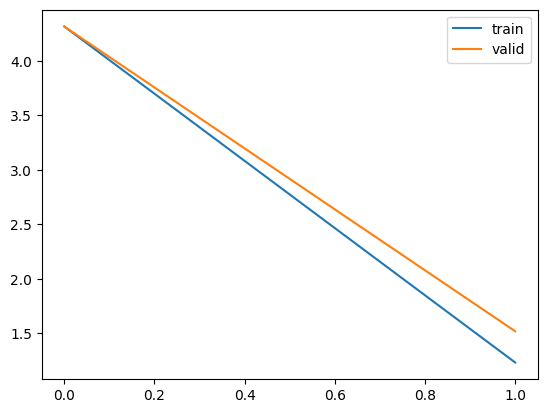

In [76]:
iter_loss_np = np.array(iter_loss)
plt.plot(iter_loss_np[:, 0], label='train')
plt.plot(iter_loss_np[:, 1], label='valid')
plt.legend()
plt.show()

In [77]:
# Prediction du texte
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(''.join(decode(model.generate(context, 500, block_size)[0].tolist())))


EDION Oxford his mother his holy face: Think
But can may hear have a reumour. 
But me!
Well, spake you forced shall knew or presy.

LUCENTIO:
ANGEpinge, sir, I cannot speak, or thou wilt dost.

MENIUS:
Enough, Warwick, you shall you be a gentleman consite
Unto the hearing of our most reclines,
Of if England soth! 'Some you owe to thee!
I am say Polixenes of you blood, Duke,
And even solemn'd. For captizence in your king,
Fall fearly the damned brows dobbsth, mistake to you,
Gorgow-poisonour spee


In [78]:
# Sauvegarde des poids
# torch.save(model.state_dict(), pathlib.Path('~/GLO-4030/datasets/transformer_nlp.pth').expanduser())

## Partie 6: Vision Transformer

Les Transformers ne sont pas limités au traitement de la langue naturelle.
Plutôt que de passer des lettres ou des mots, on peut passer des portions d'images encodés en vecteur.

Pour cette partie, nous allons entraîner un ViT (Vision Transformer) sur CIFAR10.


In [86]:
import torchvision.models

import poutyne as pt

In [87]:
# Supprimer le dernier modele
def find_cuda_tensors():
    """Finds all Python variables that are tensors on CUDA."""
    cuda_tensors = {}
    for var_name, var_value in globals().items():
        if isinstance(var_value, torch.Tensor) and var_value.is_cuda:
            cuda_tensors[var_name] = var_value
    return cuda_tensors

for tensor_name, tensor in find_cuda_tensors().items():
    del globals()[tensor_name]

if 'model' in globals():
    del model
if 'optimizer' in globals():
    del optimizer
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [88]:
# Data
batch_size = 128

transform_train = T.Compose([
    T.RandAugment(4, 14),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar, cifar_test = ddatasets.load_cifar10()
cifar.transform = transform_train
cifar_test.transform = transform_test

train_split = 0.8
num_data = len(cifar)
indices = np.arange(num_data)
np.random.shuffle(indices)

split = math.floor(train_split * num_data)
train_idx, valid_idx = indices[:split], indices[split:]

train_dataset = torch.utils.data.Subset(cifar, train_idx)
valid_dataset = torch.utils.data.Subset(cifar, valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size)

In [89]:
pathlib.Path('logs').mkdir(exist_ok=True, parents=True)

epoch = 100
learning_rate = 1e-4

img_size = cifar[0][0].shape[-1]
patch_size = 8
num_layers = 12
num_heads = 12
hidden_dim = 768
mlp_dim = 3072

model = torchvision.models.VisionTransformer(img_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim, dropout=0.1, attention_dropout=0.1, num_classes=10)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model = pt.Model(model, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

history = model.fit_generator(train_loader, valid_loader, epochs=epoch, callbacks=[
    pt.ModelCheckpoint('logs/best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),
])

dtrain.History(history).display()

test_loss, test_acc = model.evaluate_generator(test_loader)
print('test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 11.61 GiB of which 62.94 MiB is free. Including non-PyTorch memory, this process has 8.40 GiB memory in use. Of the allocated memory 7.87 GiB is allocated by PyTorch, and 227.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [90]:
model.load_weights('logs/best_epoch_5.ckpt', weights_only=True)
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 5: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

TypeError: Model.load_weights() got an unexpected keyword argument 'weights_only'

## Extra

### Transformers annotés

On vous recommande de consulter [willGuimont/transformers](https://github.com/willGuimont/transformers) pour mieux comprendre les modèles de Transformer.
Le projet implémente plusieurs architectures basées sur les Transformers; le code est bien commenté et devrait être facile à suivre.


### Self-attention vs Cross-attention

Dans les exemples utilisés dans ce laboratoire, $q$, $k$ et $v$ sont dérivés d'une seule valeur (`x = layer(x, x, x, mask)` dans le `TransformerEncoder`.
Ceci est appelé du "self-attention".

Il est aussi possible de faire du "cross-attention", lorsque $q$ et $(k, v)$ proviennent de données différentes.

[Perceiver](https://www.deepmind.com/publications/perceiver-general-perception-with-iterative-attention) et [PerceiverIO](https://www.deepmind.com/open-source/perceiver-io) sont de beaux exemples d'utilisation du "cross-attention".


### TransformerDecoder

Voici une implémentation du TransformerDecoder de "Attention Is All You Need".


In [91]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, dim_model: int, num_head: int, dropout: float):
        super().__init__()
        head_size = dim_model // num_head
        self.self_attention = MultiHeadAttention(num_head, dim_model, head_size, dropout)
        self.norm1_target = nn.LayerNorm(dim_model)
        self.norm1_memory = nn.LayerNorm(dim_model)
        
        self.norm2 = nn.LayerNorm(dim_model)
        self.cross_attention = MultiHeadAttention(num_head, dim_model, head_size, dropout)
        
        self.norm3 = nn.LayerNorm(dim_model)
        self.dropout = nn.Dropout(dropout)
        self.ffn = FeedForward(dim_model, dropout)
    
    def forward(self, target, memory, self_attention_mask=None, cross_attention_mask=None):
        target, memory = self.norm1_target(target), self.norm1_memory(memory)
        target = target + self.self_attention(target, target, target, self_attention_mask)
        target = target + self.cross_attention(self.norm2(target), memory, memory, cross_attention_mask)
        return target + self.ffn(self.norm3(target))
    
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, out_size: int, dropout: float):
        super().__init__()
        self.layers = nn.ModuleList([TransformerDecoderLayer(dim_model, num_heads, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(dim_model)
        self.fc = nn.Linear(dim_model, out_size)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, target, memory, self_attention_mask=None, cross_attention_mask=None):
        num_tokens, dim = target.shape[1], target.shape[2]
        target += position_encoding(num_tokens, dim, target.device)
        for layer in self.layers:
            target = layer(target, memory, self_attention_mask, cross_attention_mask)
        target = self.norm(target)
        target = self.fc(target)
        return target
    
dec = TransformerDecoder(6, 10, 5, 100, 0.0)
target = torch.randn((2, 5, 10))
memory = torch.randn((2, 5, 10))
print(dec(target, memory).shape)

torch.Size([2, 5, 100])


### Exemple d'implémentation de ViT

In [92]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size: int, patch_size: int, num_classes: int, channels: int, num_layers: int, dim_model: int, num_heads: int, out_size: int, dropout: float):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = channels * patch_size * patch_size
        
        self.norm1 = nn.LayerNorm(self.patch_dim)
        self.fc1 = nn.Linear(self.patch_dim, dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        
        self.cls = nn.Parameter(torch.randn((1, 1, dim_model)))
        self.dropout = nn.Dropout(dropout)
        self.trans_enc = TransformerEncoder(num_layers, dim_model, num_heads, out_size, dropout)
        
        self.norm3 = nn.LayerNorm(dim_model)
        self.fc2 = nn.Linear(dim_model, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        size = 8
        stride = 1
        
        # Image to patches
        x = self._img_to_patch_emdedding(x)
        
        # Add cls token
        cls = ein.repeat(self.cls, '1 1 d -> b 1 d', b=batch_size)
        x = torch.cat((cls, x), dim=1)
        
        # Positional encoding
        batch_size, num_tokens, dim = x.shape
        x += position_encoding(num_tokens, dim, x.device)
        
        # Dropout
        x = self.dropout(x)
        
        # Transformer
        x = self.trans_enc(x)

        
        # Final prediction from cls token
        x = x[:, 0]
        x = self.fc2(self.norm3(x))

        return x
    
    def _img_to_patch_emdedding(self, img):
        x = ein.rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.norm1(x)
        x = self.fc1(x)
        x = self.norm2(x)
        return x

In [93]:
epoch = 100
batch_size = 256
learning_rate = 1e-4

img_size = 32
patch_size = 8
num_classes = 10
channels = 3
num_layers = 6
dim_model = 512
num_heads = 12
out_size = dim_model
dropout = 0.1

model = VisionTransformer(img_size, patch_size, num_classes, channels, num_layers, dim_model, num_heads, out_size, dropout)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model = pt.Model(model, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

history = model.fit_generator(train_loader, valid_loader, epochs=epoch, callbacks=[
    pt.ModelCheckpoint('logs/vit_best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),
])

dtrain.History(history).display()

test_loss, test_acc = model.evaluate_generator(test_loader)
print('test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

Epoch:   1/100 Train steps: 313 Val steps: 79 14.78s loss: 2.160198 acc: 19.012500 val_loss: 2.002507 val_acc: 26.100000
Epoch 1: val_acc improved from -inf to 26.10000, saving file to logs/vit_best_epoch_1.ckpt
Epoch:   2/100 Step:  55/313  17.57% |███▌                |ETA: 10.40s loss: 1.980486 acc: 22.656250

KeyboardInterrupt: 

### Attention comme passage de messages
- L'attention peut être interprété comme du passage de message sur un graphe.
- Chaque noeud $i$ dans le graphe possède un triplet $(q_i, k_i, v_i$)
- Grâce à $k_i$, chaque noeud "diffuse" ce qu'il connait
- Grâce à $q_i$, chaque noeud demande aux autres noeuds de l'information
- Selon ce que l'affinité entre les $q_i$ et les $k_i$, chaque noeud aggrège l'information $v_i$ de ses voisins
- Champ réceptif large, chaque noeud à accès aux autres noeuds en une seule opération.

<div>
<img src="../docs/simplex_graph.png" width="500"/>
</div>

- Cette interprétation est cohérente avec la notion que les transformers sont des fonctions d'ensemble vers ensemble (invariance à l'ordre des éléments), la position des noeuds n'a pas d'importance, on doit encoder l'information sur la position autrement.